In [27]:
#default_exp umap_all

# UMAP reduction of all COI

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from importlib import reload
from ehv import core
from joblib import load, dump
from pathlib import Path

plt.rcParams['figure.facecolor'] = 'white'

numpy.random.seed(42)

In [30]:
# export
import umap
import dask.dataframe as dd
from ehv import core, load as e_load, correlation
from joblib import dump, load
from pathlib import Path
from matplotlib import cm
import matplotlib
import statsmodels.api as sm
import uuid
from matplotlib import cm
from sklearn.neighbors import kneighbors_graph
import scipy.spatial.distance
import scipy.sparse
from sklearn.preprocessing import scale, robust_scale, minmax_scale
from sklearn.feature_selection import VarianceThreshold

In [93]:
samples = None
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    samples, "Low/*.cif")
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)
df = e_load.clean_column_names(df)

In [94]:
df = df[df["meta_label_coi"]]
df.shape

(339045, 113)

In [95]:
with open("data/selected_features_low.txt") as fh:
    features = [i.lower() for i in fh.read().split(",")]
features.extend(df.filter(regex="meta").columns.values.tolist())

df = df[features]

In [96]:
import re
reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

In [97]:
def do_low_variance_filter(df):
    v = VarianceThreshold(0.01).fit(df.filter(regex="feat"))
    cols = df.filter(regex="feat").columns[v.get_support()]
    cols = cols.append(df.filter(regex="meta").columns)
    return df[cols]

df = do_low_variance_filter(df)

In [98]:
df.shape

(339045, 77)

In [99]:
correlated_features = correlation.get_correlated_features(df.filter(regex="feat"), thresh=0.89)
df = df.drop(columns=correlated_features)
df.shape

(339045, 60)

In [88]:
df[df.filter(regex="feat").columns] = minmax_scale(df.filter(regex="feat"))

In [ ]:
df[df.filter(regex="feat").columns] = scale(df.filter(regex="feat"))

In [77]:
def do_minmax_scale(df):
    df[df.filter(regex="feat").columns] = minmax_scale(df.filter(regex="feat"))
    return df

df = df.groupby(["meta_timepoint", "meta_replicate"]).apply(do_minmax_scale)

In [89]:
def do_zscore_scale(df):
    df[df.filter(regex="feat").columns] = scale(df.filter(regex="feat"))
    return df

df = df.groupby(["meta_timepoint", "meta_replicate"]).apply(do_zscore_scale)

In [40]:
def do_robust_scale(df):
    df[df.filter(regex="feat").columns] = robust_scale(df.filter(regex="feat"), quantile_range=(0.05, 0.95))
    return df

df = df.groupby(["meta_timepoint", "meta_replicate"]).apply(do_robust_scale)

## Compute UMAP on all cells of interest

In [100]:
model = umap.UMAP(random_state=42, metric="correlation")

In [56]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95).fit_transform(df.filter(regex="feat"))
pca.shape

(293029, 39)

In [101]:
%%time
projection = model.fit_transform(df.filter(regex="feat"))

CPU times: user 21min 33s, sys: 4min 11s, total: 25min 44s
Wall time: 4min 53s


In [102]:
dump(projection, "/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/%s.dat" % uuid.uuid4())

['/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/10570fae-537e-4441-80b7-96ba6886cf2e.dat']

In [59]:
projection = load("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/49609583-2baa-4746-aa92-9d0ce8735d0e.dat")

In [103]:
df["dim_1"] = projection[:, 0]
df["dim_2"] = projection[:, 1]

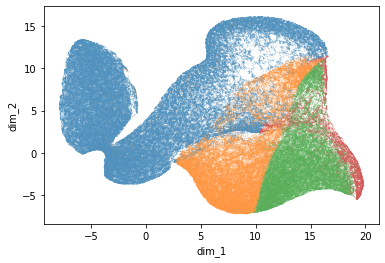

In [104]:
seaborn.scatterplot(data=df[df["meta_label"] != "unknown"], x="dim_1", y="dim_2", hue="meta_label", s=0.5, alpha=0.5, legend=False, hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg"])
plt.savefig("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/assets/thumbs/10570fae-537e-4441-80b7-96ba6886cf2e.jpg")

In [170]:
# export
def knn_umap_plot(df, ax, fig=None, colorbar=True, cmap="cool", metric="cosine"):
    knn = scipy.sparse.tril(kneighbors_graph(df.filter(regex="feat"), n_jobs=-1, n_neighbors=5, metric=metric)).toarray()
    dists = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(df[["dim_1", "dim_2"]], "euclidean"))
    
    norm = matplotlib.colors.Normalize(vmin=dists.min(), vmax=dists.max())
    cmap = cm.get_cmap(cmap)
    for i in range(knn.shape[0]):
        for j in knn[i].nonzero()[0]:
            xx = [df.iloc[i]["dim_1"], df.iloc[j]["dim_1"]]
            yy = [df.iloc[i]["dim_2"], df.iloc[j]["dim_2"]]
            ax.plot(xx, yy, alpha=0.2, c=cmap(norm(dists[i, j])), linewidth=.5)
            
    if colorbar:
        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

CPU times: user 51.3 s, sys: 2.48 s, total: 53.8 s
Wall time: 49.2 s


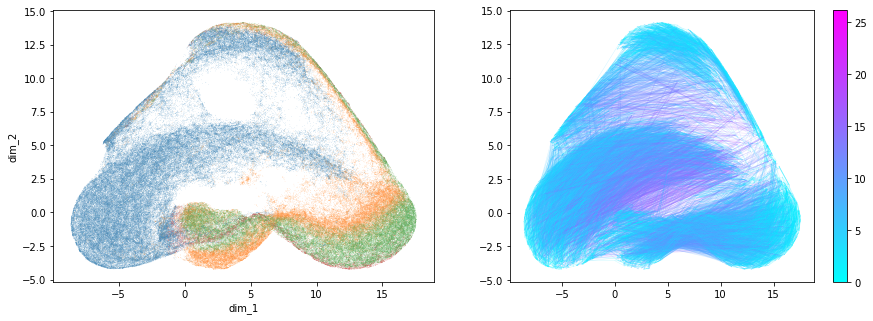

In [176]:
%%time
from sklearn.neighbors import kneighbors_graph
import scipy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
seaborn.scatterplot(data=df[df["meta_label"] != "unknown"], x="dim_1", y="dim_2", hue="meta_label", s=0.2, alpha=0.5, legend=False, ax=ax1, hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg"])

sample = df.sample(n=10000)
knn_umap_plot(sample, ax2, fig, True)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

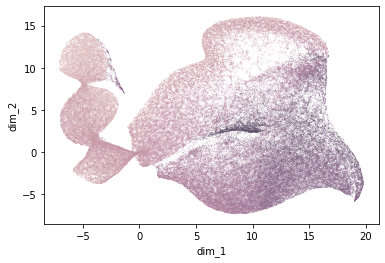

In [62]:
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", hue="meta_timepoint", s=0.2, alpha=0.5, legend=False)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

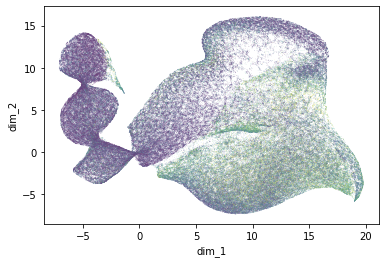

In [63]:
feat = "feat_area_m07"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", c=df[feat], s=0.2, alpha=0.5, cmap="viridis", norm=norm)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

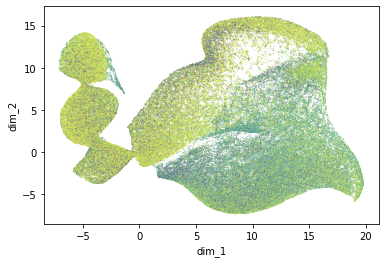

In [64]:
feat = "feat_aspect_ratio_intensity_m07_ch7"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", c=df[feat], s=0.5, alpha=0.5, cmap="viridis", norm=norm)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

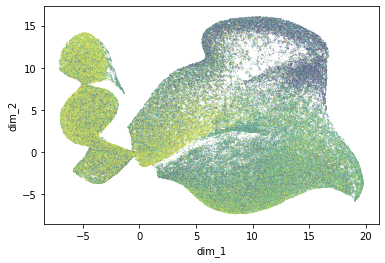

In [65]:
feat = "feat_aspect_ratio_m01"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", c=df[feat], s=0.5, alpha=0.5, cmap="viridis", norm=norm)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

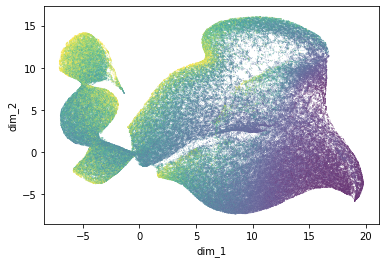

In [66]:
feat = "feat_intensity_mc_ch11"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", c=df[feat], s=0.5, alpha=0.5, cmap="viridis", norm=norm)

In [71]:
corr = df.filter(regex="feat|dim").corr()

In [72]:
corr["dim_2"].abs().sort_values(ascending=False)[:20]

dim_2                                      1.000000
feat_max_pixel_mc_ssc                      0.574384
feat_area_m04                              0.480988
feat_intensity_mc_ssc                      0.477024
feat_intensity_mc_ch04                     0.473089
feat_bright_detail_intensity_r3_mc_ch04    0.430224
feat_intensity_mc_ch11                     0.421485
feat_median_pixel_m09_bf2                  0.383088
feat_modulation_m04_ch04                   0.366197
feat_max_pixel_mc_ch11                     0.354962
feat_contrast_m04_ch04                     0.320733
feat_contrast_m09_bf2                      0.312759
feat_contrast_m01_bf                       0.307120
feat_modulation_m06_ssc                    0.303282
feat_gradient_rms_m11_ch11                 0.279197
feat_area_m11                              0.256658
feat_max_pixel_mc_bf2                      0.254722
feat_bright_detail_intensity_r3_mc_ch03    0.247990
feat_width_m11                             0.246482
feat_area_m0

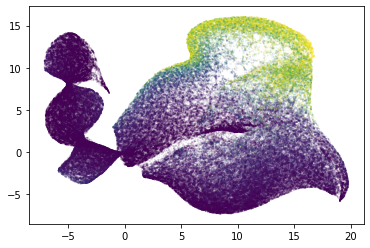

In [73]:
feat = "feat_max_pixel_mc_ssc"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
plt.scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.01, alpha=0.5, cmap="viridis", norm=norm)

In [74]:
corr["dim_1"].abs().sort_values(ascending=False)[:20]

dim_1                                      1.000000
feat_intensity_mc_ch11                     0.690554
feat_max_pixel_mc_ch11                     0.632633
feat_area_m04                              0.512340
feat_bright_detail_intensity_r3_mc_ch03    0.463523
feat_modulation_m06_ssc                    0.427163
feat_bright_detail_intensity_r3_mc_ch04    0.423916
feat_intensity_mc_ch04                     0.402555
feat_width_m11                             0.394776
feat_modulation_m04_ch04                   0.382430
feat_area_m07                              0.380751
feat_area_m11                              0.372534
feat_area_mc                               0.367201
feat_max_pixel_mc_ssc                      0.359649
feat_contrast_m04_ch04                     0.357335
feat_area_m06                              0.357329
feat_bright_detail_intensity_r3_mc_bf      0.346653
feat_intensity_mc_ssc                      0.339024
feat_gradient_rms_m07_ch7                  0.334556
feat_aspect_

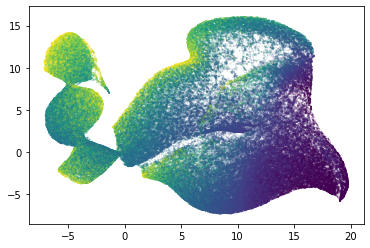

In [75]:
feat = "feat_intensity_mc_ch11"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
plt.scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.01, cmap="viridis", norm=norm)

# Compare UMAPs

In [164]:
uuids = [
    "753c2943-2030-442d-b1f8-9bdcff81404b",
    "08990f80-d617-4361-8c6c-e490b5688de8",
    "2fb60822-4d6e-4067-914e-bc5311b3e713",
    "97c6df51-ac2c-4630-aeca-f4b56f5c44ff",
    "b16c9031-5995-4193-b0f7-23fddec6a215",
    "9f098f80-28e1-4127-9ee4-b925602f051c"
]

for i, u in enumerate(uuids):
    projection = load("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/%s.dat" % u)
    df["umap%d_dim1" % i] = projection[: , 0]
    df["umap%d_dim2" % i] = projection[: , 1]

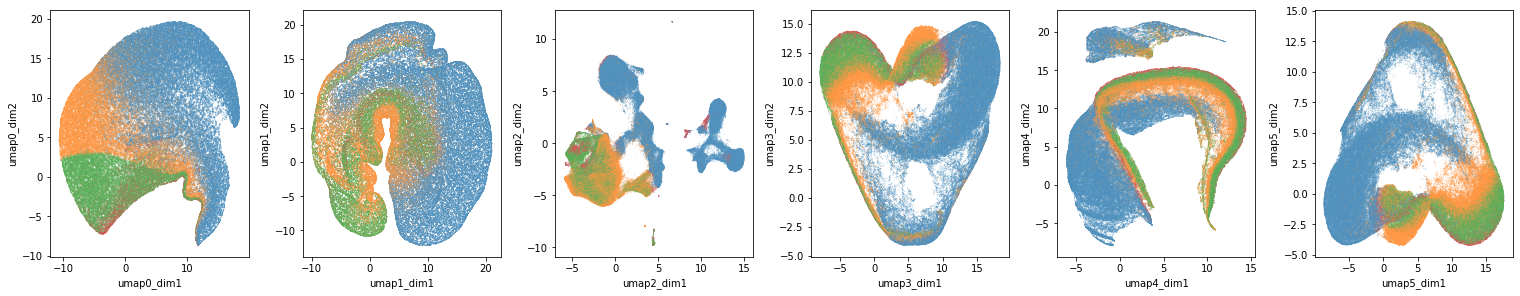

In [165]:
fig, axes = plt.subplots(1, len(uuids), constrained_layout=True, figsize=(21,4))
axes = axes.ravel()

for i, ax in enumerate(axes):
    seaborn.scatterplot(
        data=df[df["meta_label"] != "unknown"], 
        x="umap%d_dim1" % i, y="umap%d_dim2" % i, hue="meta_label", 
        s=0.5, alpha=0.5, legend=False, 
        hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg"],
        ax=ax
    )